Natural Language Processing for Data Mining Project

Importing the libraries needed for project

In [263]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Importing Training Data and Testing Data

In [264]:
train_tweets = pd.read_csv('training_tweets.csv')
test_tweets = pd.read_csv('testing_tweets_tsla.csv')

In [265]:
# deleting any null rows that way the dataset is clean

train_tweets = train_tweets.dropna()
test_tweets = test_tweets.dropna()

In [266]:
train_tweets = train_tweets[['label','tweets']]
test = test_tweets['tweets']

Visualizing the labels for each data object, 1 for positive, 0 for negative

<AxesSubplot:xlabel='label', ylabel='count'>

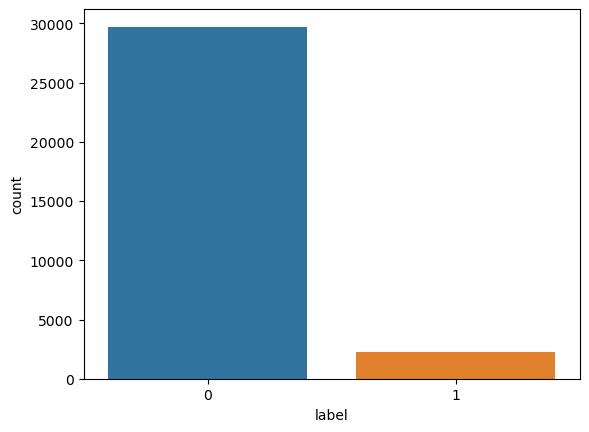

In [267]:
sns.countplot(x= 'label',data = train_tweets)

Data Preprocessing and Feature Engineering

In [268]:
# removal of punctuations

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

In [269]:
# removes commonly used words, known as stop words

def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

In [270]:
# normalizes the tweet, takes words that are typed multiple times
# multiple typed words have the same meaning despite the multiplicity

def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet

Example of how this preprocessing looks on real data

In [271]:
# This will show how each tweet will be preprocessed before feeding into ML Algorithm

tweet_example = train_tweets['tweets'][279]
print(tweet_example)

# removal of punctuation
temp = form_sentence(tweet_example)
print(temp)

# removal of stop words
temp2 = no_user_alpha(temp)
print(temp2)

# normalization of the tweet
temp3 = normalization(temp2)
print(temp3)

 @user aaahh! nabilah looks so   ð   arigatou jkt48! have a very happy daaay âºï¸ #iwearbanana  
user aaahh nabilah looks so ð arigatou jkt48 have a very happy daaay âºï¸ iwearbanana
['aaahh', 'nabilah', 'looks', 'arigatou', 'happy', 'daaay', 'iwearbanana']
['aaahh', 'nabilah', 'look', 'arigatou', 'happy', 'daaay', 'iwearbanana']


Function to do Feature Engineering all in one

In [272]:
def tweet_scrubber(tweet):
    temp1 = form_sentence(tweet)
    temp2 = no_user_alpha(temp1)
    temp3 = normalization(temp2)

    return temp3

# example of what the scrubber is going to do
tweet_scrubber(train_tweets['tweets'][279])

['aaahh', 'nabilah', 'look', 'arigatou', 'happy', 'daaay', 'iwearbanana']

Apply Feature Engineering to each Tweet

In [273]:
# this will apply the function to scrub the tweets to make sure they are ready to be fed into ML Pipeline
train_tweets['tweet_list'] = train_tweets['tweets'].apply(tweet_scrubber)
test_tweets['tweet_list'] = test_tweets['tweets'].apply(tweet_scrubber)

# example of how the new dataframe would look

train_tweets[train_tweets['label']==1].drop('tweets',axis=1).head()

,label,tweet_list
13,1,"[cnn, call, michigan, middle, school, wall, ch..."
14,1,"[comment, australia, opkillingbay, seashepherd..."
17,1,"[retweet, agree]"
23,1,"[lumpy, say, prove, lumpy]"
34,1,"[unbelievable, century, need, something, like,..."


Applying Naive Bayes Machine Learning Classifier

In [275]:
x = train_tweets['tweets']
y = train_tweets['label']
test = test_tweets['tweets']

In [276]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(train_tweets['tweets'], train_tweets['label'], test_size=0.2)

In [277]:
#Machine Learning Pipeline

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=tweet_scrubber)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function tweet_scrubber at 0x29eaa30a0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [278]:
predictions = pipeline.predict(msg_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6320
           1       0.16      1.00      0.27        73

    accuracy                           0.94      6393
   macro avg       0.58      0.97      0.62      6393
weighted avg       0.99      0.94      0.96      6393



[[5931  389]
 [   0   73]]
0.9391521977162521
